In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:

block_size = 3
X, Y = [], []
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:

def build_dataset(words):
    
    block_size = 3
    X, Y = [], []
    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27,2))

In [8]:
C[5]

tensor([2.5429, 0.1503])

In [9]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([2.5429, 0.1503])

In [10]:
C[[5,6]]

tensor([[ 2.5429,  0.1503],
        [ 1.9842, -1.5086]])

In [11]:
C[torch.tensor([5,6,7,7,7])]

tensor([[ 2.5429,  0.1503],
        [ 1.9842, -1.5086],
        [ 0.5908,  1.7614],
        [ 0.5908,  1.7614],
        [ 0.5908,  1.7614]])

In [12]:
C[X].shape

torch.Size([228146, 3, 2])

In [13]:
X[3,2]

tensor(13)

In [14]:
C[X][3, 2]

tensor([ 0.2819, -1.5379])

In [15]:
C[13]

tensor([ 0.2819, -1.5379])

In [16]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [17]:
W1 = torch.randn((6,100))
b1 = torch.randn((100))

In [18]:
torch.cat([emb[:, 0, :] , emb[:, 1, :] , emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [19]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [20]:
h = torch.tanh(emb.view(-1, 6) @  W1 + b1)

In [21]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [22]:
logits = h @ W2 + b2

In [23]:
logits.shape

torch.Size([228146, 27])

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1,keepdims = True)

In [26]:
prob.shape

torch.Size([228146, 27])

In [27]:
prob[0].sum()

tensor(1.0000)

In [28]:
loss = -prob[torch.arange(32), Y].log().mean()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
loss

In [27]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [38]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

13151

In [40]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [41]:
lri = []
lossi = []
stepi = []

In [42]:
for i in range(180000):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i] 
    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

#print(loss.item())

In [43]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1168, grad_fn=<NllLossBackward0>)

In [44]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1646, grad_fn=<NllLossBackward0>)

In [45]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1601, grad_fn=<NllLossBackward0>)

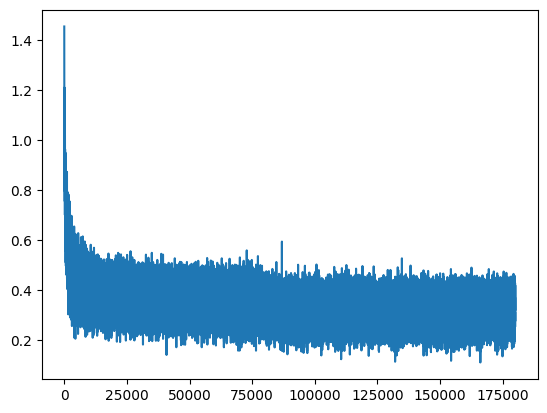

In [46]:
plt.plot(stepi, lossi)

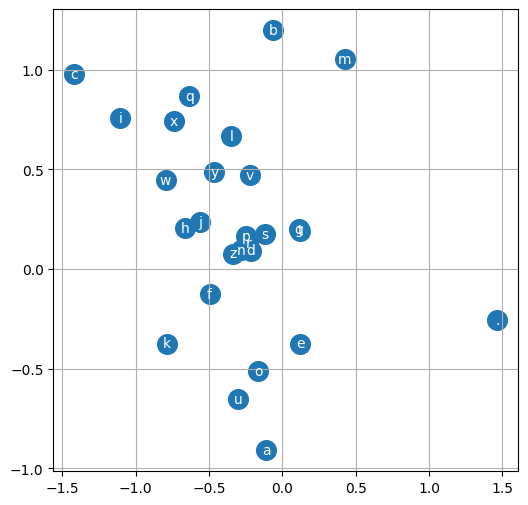

In [47]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

junide.
jakarie.
presaygen.
makovin.
tolian.
juez.
kalinaa.
zamilena.
jededaine.
amel.
seon.
evy.
arte.
faveusthynol.
maj.
ponis.
jah.
jaylinora.
yae.
ocerrenabi.
